In [1]:
import sys
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable, Optional, List

In [42]:
def cv2_imshow(img: np.ndarray):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


def preprocess(img: np.ndarray):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (13, 13), 0)
    return blurred
    # Use adaptive threshold for robust lighting handling
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    return thresh


def find_contours(img: np.ndarray):

    img = cv2.Canny(img, 50, 150)
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    detected_cards = []
    for contour in contours:
        contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Approximate contour to a polygon
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
    
        # Check if it is a rectangle (4 sides) and reasonably large
        if len(approx) == 4 and cv2.contourArea(approx) > 1000:
            # Check aspect ratio of the bounding box
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = float(w) / h
            
            #if 0.6 < aspect_ratio < 1.6:  # Card-like shape (adjust if needed)
            detected_cards.append(approx)
            cv2.drawContours(img, [approx], -1, (0, 255, 0), 10)
    print(len(detected_cards))
    return img


def detect_white_pixels(img: np.ndarray):
    """

    Parameters
    ----------
    img : np.ndarray
        H x W x 3 (BGR)
    """
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_white = np.array([0, 0, 180])
    upper_white = np.array([180, 50, 255])

    white_mask = cv2.inRange(hsv_img, lower_white, upper_white)

    return cv2.bitwise_and(img, img, mask=white_mask)


def convert_red_pixels_to_white(img: np.ndarray):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])

    red_mask = cv2.inRange(hsv_img, lower_red, upper_red)
    return cv2.bitwise_and(img, img, mask=red_mask)


def detect_white_pixels_clahe(img: np.ndarray):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Apply CLAHE to the V channel (brightness)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    hsv[:, :, 2] = clahe.apply(hsv[:, :, 2])

    # Detect white in normalized image
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 30, 255])
    mask = cv2.inRange(hsv, lower_white, upper_white)
    kernel = np.ones((5, 5), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel, iterations=1)
    return cv2.bitwise_and(img, img, mask=dilated_mask)


# test solution
def test_solution(
    func: List[Callable],
    test_folder: Path, 
    output_dir: Optional[Path],
):
    if output_dir is not None:
        output_dir.mkdir(parents=True, exist_ok=True)
    for img_file in test_folder.iterdir():
        img = cv2.imread(str(img_file), cv2.IMREAD_COLOR)
        for f in func:
            img = f(img)        
        if output_dir:
            cv2.imwrite(str(output_dir / img_file.name), img)
        #cv2_imshow(white_pixels)

In [ ]:
# 1 -> rename files in data folder
root_dir = Path(".").resolve().parent
data_dir = root_dir / "data" / "input"
output_test = root_dir / "data" / "preprocess-blurred"
img_test = cv2.imread(str(data_dir / "0.jpg"), cv2.IMREAD_COLOR)


In [44]:
test_solution([preprocess], data_dir, output_test)

In [36]:
# find contours

data_dir = root_dir / "data" / "preprocess-gauss-13x13"
output_test = root_dir / "data" / "contours"
test_solution([find_contours], data_dir, output_test)


12


KeyboardInterrupt: 

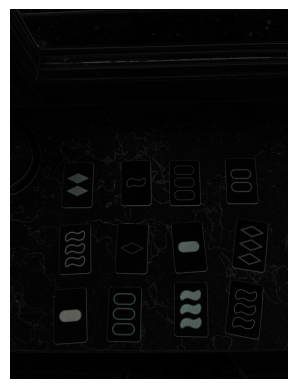

In [46]:
def calculate_gradient(img: np.ndarray):
    # Calculate the gradient using the Sobel operator
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute the gradient magnitude
    gradient_magnitude = cv2.magnitude(grad_x, grad_y)
    
    # Normalize the gradient image to the range [0, 255]
    gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX)
    
    return gradient_magnitude.astype(np.uint8)

# Convert the image to grayscale
#gray_img = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)

# Calculate the gradient image
gradient_img = calculate_gradient(img_test)

# Display the gradient image
cv2_imshow(gradient_img)

255